<a href="https://colab.research.google.com/github/YoshifumiMiyagi/VinDr-PCXR/blob/main/VinDr_PCXR_keras_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00


In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...


In [3]:
!conda install -c conda-forge gdcm -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.7.4   |       hbcca054_0         151 KB  conda-forge
    certifi-2024.7.4           |     pyhd8ed1ab_0         156 KB  conda-forge
    gdcm-2.8.9                 | py310h59700c5_10         2.7 MB  conda-forge
    json-c-0.17                |       h1220068_1          82 KB  conda-forge
    lerc-4.0.0                 |       h27087fc_0         275 KB  conda-forge
    libdeflate-1.20            |       hd590300_0          70 KB  conda-forge
    libexpat-2.6.2  

In [3]:
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import os
import cv2
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten,Input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical

In [4]:
annotation = pd.read_csv('/content/drive/MyDrive/annotations_train.csv')
label = pd.read_csv('/content/drive/MyDrive/image_labels_train.csv')
label.head()

,image_id,rad_ID,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Situs inversus,Pneumonia,Pleuro-pneumonia,Diagphramatic hernia,Tuberculosis,Congenital emphysema,CPAM,Hyaline membrane disease,Mediastinal tumor,Lung tumor
0,6cb53aff85c71b98ad13d67a131708c6,R3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40414c05687cdb156823c156967b13f0,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0e4a464dfbf8abc6333c82f1b77b6455,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f4d3fab0b71381e6b237dc36301e85a0,R3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b58c9b1c89978a0b1f8533b7a2ca1088,R3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
Case = label[label['Bronchiolitis']==1]['image_id'].tolist()
Control = label[label['No finding']==1]['image_id'].tolist()

len(Case), len(Control)

(497, 5143)

# Bronchiolitis

In [41]:
#size = 224
size = 384
img_size = (size,size)
dir_name = "/content/drive/MyDrive/train"

Bronchiolitis = []
for img in Case[0:497]:
    img_list = ('' + dir_name + '/' +img + '.dicom')
    temp_img = pydicom.dcmread(img_list)
    img_list = temp_img.pixel_array
    #temp_img_array = img_to_array(img_list) /255
    img_list_resized = cv2.resize(img_list, img_size)
    temp_img_array = img_to_array(img_list_resized) /255
    Bronchiolitis.append(temp_img_array)
Bronchiolitis = np.array(Bronchiolitis)
Bronchiolitis2 = Bronchiolitis.reshape(-1,size*size)
df_case=pd.DataFrame(Bronchiolitis2)
df_case['label'] = np.full(Bronchiolitis.shape[0],1)

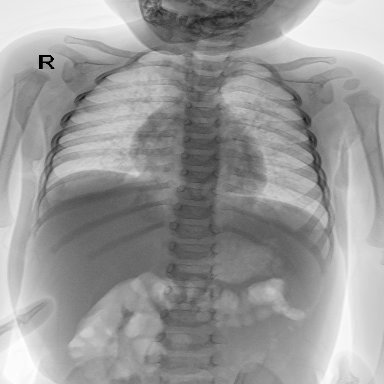

In [42]:
x = img_to_array(temp_img_array)
array_to_img(x)

# Control

In [43]:
CTRL = []
for img in Control[0:497]:
    img_list = ('' + dir_name + '/' +img + '.dicom')
    temp_img = pydicom.dcmread(img_list)
    img_list = temp_img.pixel_array
    #temp_img_array = img_to_array(img_list) /255
    img_list_resized = cv2.resize(img_list, img_size)
    temp_img_array = img_to_array(img_list_resized) /255
    CTRL.append(temp_img_array)
CTRL = np.array(CTRL)
CTRL2 = CTRL.reshape(-1,size*size)
df_ctrl=pd.DataFrame(CTRL2)
df_ctrl['label'] = np.full(CTRL.shape[0],0)

# Preparation

In [44]:
Df = pd.concat([df_case, df_ctrl], ignore_index=True)

x_train, x_test, y_train, y_test = train_test_split(Df.iloc[:,0:-1], Df.iloc[:,-1], test_size=0.20, random_state=42)

X_train = x_train.values.reshape(-1,size, size)
X_test = x_test.values.reshape(-1,size, size)

X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test = np.repeat(X_test[..., np.newaxis], 3, -1)

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [45]:
X_train.shape

(795, 384, 384, 3)

# Model

In [46]:
np.random.seed(0)
model = Sequential()

model.add(BatchNormalization(input_shape=(size, size ,3)))
#model.add(Input(shape=(224,224,1)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Bat  (None, 384, 384, 3)       12        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 384, 384, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 192, 192, 16)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 192, 192, 16)      0         
                                                                 
 flatten_1 (Flatten)         (None, 589824)            0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [95]:
model_chkpt = ModelCheckpoint('best_mod.keras', save_best_only=True, monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=False, patience=5)

In [49]:
history = model.fit(X_train, Y_train,
          validation_split=0.20,
          epochs=20, batch_size=16, shuffle=True,
          callbacks=[model_chkpt ,early_stopping]
         )

Epoch 1/20
40/40 [==============================] - 8s 184ms/step - loss: 26.2095 - accuracy: 0.5692 - val_loss: 3.6771 - val_accuracy: 0.5472
Epoch 2/20
40/40 [==============================] - 6s 154ms/step - loss: 0.9714 - accuracy: 0.5739 - val_loss: 0.7578 - val_accuracy: 0.6038
Epoch 3/20
40/40 [==============================] - 6s 150ms/step - loss: 0.6768 - accuracy: 0.6226 - val_loss: 0.6833 - val_accuracy: 0.6164
Epoch 4/20
40/40 [==============================] - 6s 153ms/step - loss: 0.6346 - accuracy: 0.6258 - val_loss: 1.3196 - val_accuracy: 0.5535
Epoch 5/20
40/40 [==============================] - 6s 155ms/step - loss: 0.6218 - accuracy: 0.6525 - val_loss: 0.6920 - val_accuracy: 0.5660
Epoch 6/20
40/40 [==============================] - 6s 153ms/step - loss: 0.5943 - accuracy: 0.6698 - val_loss: 0.6693 - val_accuracy: 0.5597
Epoch 7/20
40/40 [==============================] - 3s 69ms/step - loss: 0.6353 - accuracy: 0.6148 - val_loss: 0.6822 - val_accuracy: 0.5786
Epoch 

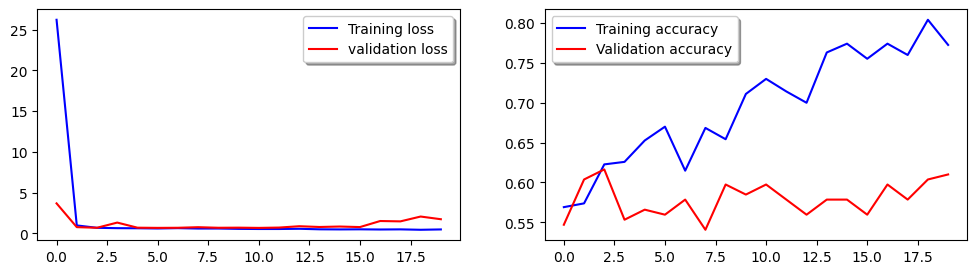

In [50]:
fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

7/7 [==============================] - 0s 36ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

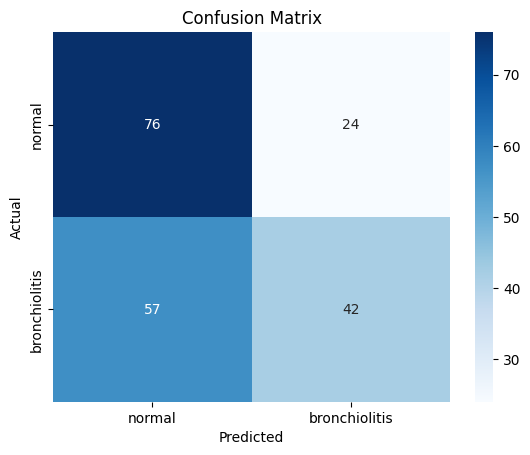

In [51]:
plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
#pred = model.predict_classes(X_test)
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

Y_TEST = np.argmax(Y_test, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['normal', 'bronchiolitis']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [52]:
print(classification_report(Y_TEST, pred))
print('normal = 0 , bronchiolitis = 1')

              precision    recall  f1-score   support

           0       0.57      0.76      0.65       100
           1       0.64      0.42      0.51        99

    accuracy                           0.59       199
   macro avg       0.60      0.59      0.58       199
weighted avg       0.60      0.59      0.58       199

normal = 0 , bronchiolitis = 1


# Transfer

In [96]:
# params we will probably want to do some hyperparameter optimization later
BASE_MODEL= 'DenseNet169' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (384, 384) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 24 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.7 # [0, 0.25, 0.5]
LEARN_RATE = 1e-3 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 200 # [3000, 6000, 15000]
TEST_SAMPLES = 100
USE_ATTN = False # [True, False]

In [97]:
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169':
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [98]:
base_pretrained_model = PTModel(input_shape =  (size, size,3),
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

51877672/51877672 [==============================] - 0s 0us/step


In [99]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply,  Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam
from keras import layers
# Get output shape from the output layer of the base model
# Get the output shape of the base model using .output
pt_features_shape = base_pretrained_model.output.shape[1:]
pt_features = Input(pt_features_shape, name = 'feature_input')
pt_features = Input(shape=base_pretrained_model.output_shape[1:], name = 'feature_input')
pt_depth = base_pretrained_model.output.shape[-1] # Extract depth from the output shape


from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
gap = GlobalAveragePooling2D()(bn_features)

gap_dr = Dropout(DROPOUT)(gap)
dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
dr_steps = BatchNormalization()(dr_steps)
dr_steps = layers.LeakyReLU(0.1)(dr_steps)
out_layer = Dense(2, activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features],
                   outputs = [out_layer], name = 'trained_model')

attn_model.summary()

Model: "trained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_input (InputLayer)  [(None, 12, 12, 1664)]    0         
                                                                 
 batch_normalization_14 (Ba  (None, 12, 12, 1664)      6656      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_6  (None, 1664)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_16 (Dropout)        (None, 1664)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               212992    
                                                                 
 dropout_17 (Dropout)        (None, 128)             

In [100]:
from keras.models import Sequential
from keras.optimizers import Adam

pneu_model = Sequential(name = 'combined_model')
pneu_model.add(Input(shape=base_pretrained_model.input_shape[1:], name = 'feature_input'))
base_pretrained_model.trainable = False
pneu_model.add(base_pretrained_model)
pneu_model.add(attn_model)
pneu_model.compile(optimizer = Adam(learning_rate = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])
pneu_model.summary()

Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 12, 12, 1664)      12642880  
                                                                 
 trained_model (Functional)  (None, 2)                 220418    
                                                                 
Total params: 12863298 (49.07 MB)
Trainable params: 216834 (847.01 KB)
Non-trainable params: 12646464 (48.24 MB)
_________________________________________________________________


In [101]:
history = pneu_model.fit(X_train, Y_train,
          validation_split=0.20,
          epochs=20, batch_size=16, shuffle=True,
          callbacks=[model_chkpt ,early_stopping]
         )

Epoch 1/20
40/40 [==============================] - 42s 672ms/step - loss: 0.8057 - accuracy: 0.5535 - val_loss: 0.7460 - val_accuracy: 0.5786
Epoch 2/20
40/40 [==============================] - 10s 239ms/step - loss: 0.6997 - accuracy: 0.6305 - val_loss: 0.6933 - val_accuracy: 0.6101
Epoch 3/20
40/40 [==============================] - 10s 241ms/step - loss: 0.6716 - accuracy: 0.6415 - val_loss: 0.6530 - val_accuracy: 0.6352
Epoch 4/20
40/40 [==============================] - 8s 188ms/step - loss: 0.6756 - accuracy: 0.6274 - val_loss: 0.6480 - val_accuracy: 0.6289
Epoch 5/20
40/40 [==============================] - 10s 254ms/step - loss: 0.6413 - accuracy: 0.6415 - val_loss: 0.6426 - val_accuracy: 0.6415
Epoch 6/20
40/40 [==============================] - 10s 243ms/step - loss: 0.6445 - accuracy: 0.6462 - val_loss: 0.6357 - val_accuracy: 0.6604
Epoch 7/20
40/40 [==============================] - 8s 191ms/step - loss: 0.6132 - accuracy: 0.6714 - val_loss: 0.6279 - val_accuracy: 0.6478
E

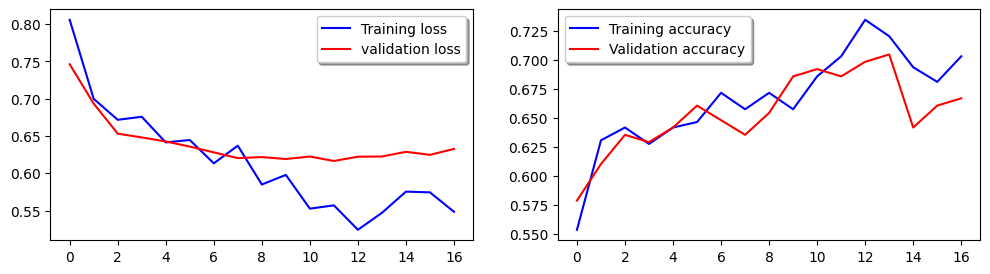

In [102]:
fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

7/7 [==============================] - 20s 1s/step


<function matplotlib.pyplot.show(close=None, block=None)>

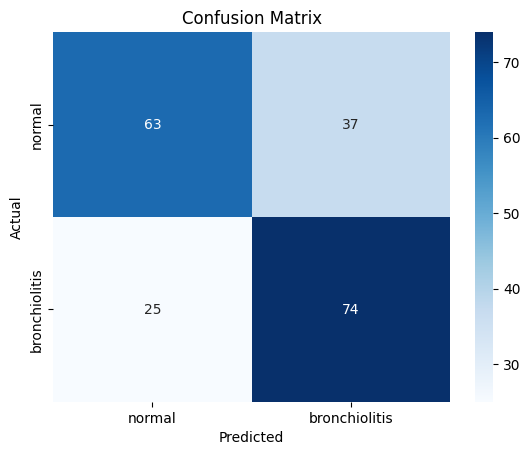

In [103]:
plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
#pred = model.predict_classes(X_test)
pred_probs = pneu_model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

Y_TEST = np.argmax(Y_test, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['normal', 'bronchiolitis']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [104]:
print(classification_report(Y_TEST, pred))
print('normal = 0 , bronchiolitis = 1')

              precision    recall  f1-score   support

           0       0.72      0.63      0.67       100
           1       0.67      0.75      0.70        99

    accuracy                           0.69       199
   macro avg       0.69      0.69      0.69       199
weighted avg       0.69      0.69      0.69       199

normal = 0 , bronchiolitis = 1
